# Metocean track comparison

Comparing MIKE 21 HD dfsu model result with satellite track observation of surface elevation. 

This notebook also includes gridded spatial skill assessments. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import modelskill as ms

## Extract track data

In [2]:
mr = ms.model_result('../tests/testdata/NorthSeaHD_and_windspeed.dfsu',
                     name='HD', item=0)
mr

<DfsuModelResult>: HD
Time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00
Quantity: Surface Elevation [m]

In this case, the track observations are stored in a csv file, which we can read in using pandas.
Any file format that can be read into a pandas dataframe can be used here.

In [3]:
df = pd.read_csv('../tests/testdata/altimetry_NorthSea_20171027.csv',
                  index_col=0, parse_dates=True)
df.head()

,lon,lat,surface_elevation,significant_wave_height,wind_speed
date,,,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449,0.426,6.100000
2017-10-26 04:37:54,8.221631,54.948459,1.1200,1.634,9.030000
2017-10-26 04:37:55,8.189390,55.008547,1.0882,1.717,9.370000
2017-10-26 04:37:56,8.157065,55.068627,1.0309,1.869,9.559999
2017-10-26 04:37:58,8.124656,55.128700,1.0369,1.939,9.980000


Csv files have no metadata on which quantity it contains, we add this manually, consistent with the model result.

In [4]:
o1 = ms.TrackObservation(df, item="surface_elevation", name='alti',
                         quantity=ms.Quantity(name="Surface Elevation", unit="meter")) 
o1

/home/jan/src/modelskill/modelskill/timeseries/_track.py:135: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<TrackObservation>: alti
Time: 2017-10-26 04:37:37 - 2017-10-30 20:54:47
Quantity: Surface Elevation [meter]

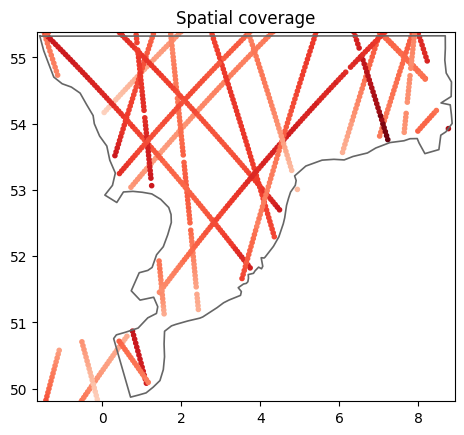

In [5]:
ms.plotting.spatial_overview(o1, mr);

In [6]:
cmp = ms.match(o1, mr)
cmp

<Comparer>
Quantity: Surface Elevation [meter]
Observation: alti, n_points=532
Model(s):
0: HD

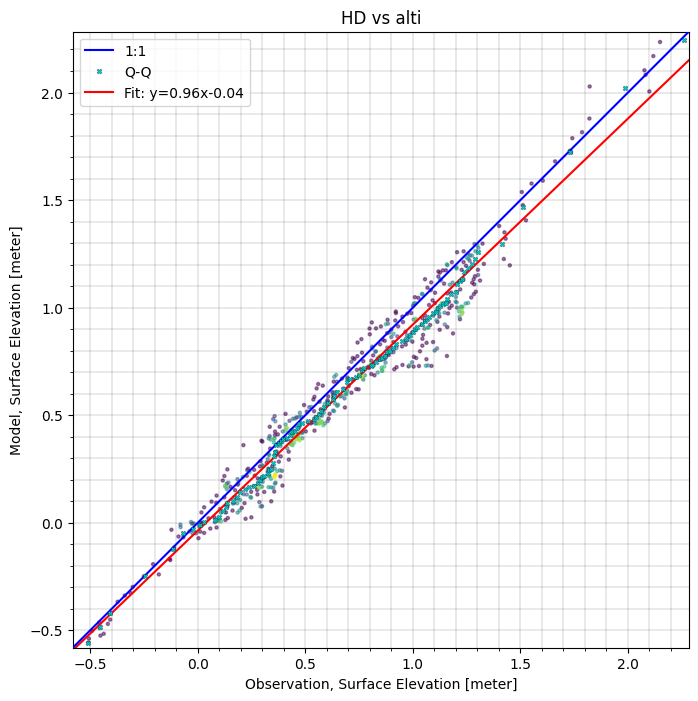

In [7]:
cmp.plot.scatter();

## Extract track from dfs0

Using the `TrackModelResult` class.

In [8]:
mr = ms.TrackModelResult('../tests/testdata/NorthSeaHD_extracted_track.dfs0',
                          name='HD', item=2)
mr

/home/jan/src/modelskill/modelskill/timeseries/_track.py:135: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<TrackModelResult>: HD
Time: 2017-10-26 04:37:37 - 2017-10-30 20:54:47
Quantity: Undefined [undefined]

In [9]:
df = pd.read_csv('../tests/testdata/altimetry_NorthSea_20171027.csv',
                  index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti',
                         quantity=ms.Quantity(name="Surface Elevation", unit="meter"))
o1

/home/jan/src/modelskill/modelskill/timeseries/_track.py:135: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<TrackObservation>: alti
Time: 2017-10-26 04:37:37 - 2017-10-30 20:54:47
Quantity: Surface Elevation [meter]

In [10]:
cmp = ms.match(o1, mr)
cmp

<Comparer>
Quantity: Surface Elevation [meter]
Observation: alti, n_points=532
Model(s):
0: HD

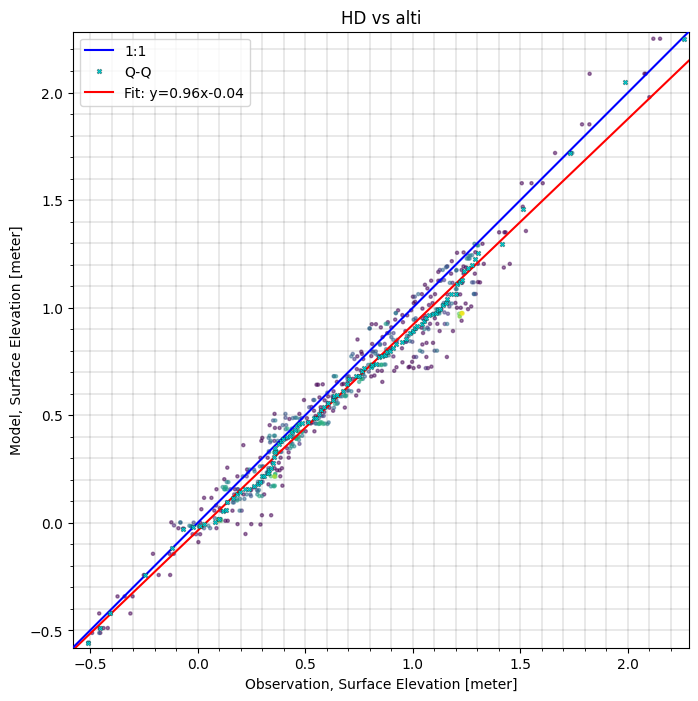

In [11]:
cmp.plot.scatter();

## Gridded skill

Load model, load observation, add observation to model and extract.

In [12]:
mr = ms.model_result('../tests/testdata/NorthSeaHD_and_windspeed.dfsu',
                     name='HD', item=0)

df = pd.read_csv('../tests/testdata/altimetry_NorthSea_20171027.csv',
                 index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti',
                         quantity=ms.Quantity(name="Surface Elevation", unit="meter"))
cmp = ms.match(o1, mr)
cmp

/home/jan/src/modelskill/modelskill/timeseries/_track.py:135: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<Comparer>
Quantity: Surface Elevation [meter]
Observation: alti, n_points=532
Model(s):
0: HD

Get metrics binned by a regular spatial grid, returns xarray Dataset

In [13]:
gs = cmp.gridded_skill(metrics=['bias'])
gs

<SkillGrid>
Dimensions: (x: 5, y: 5)

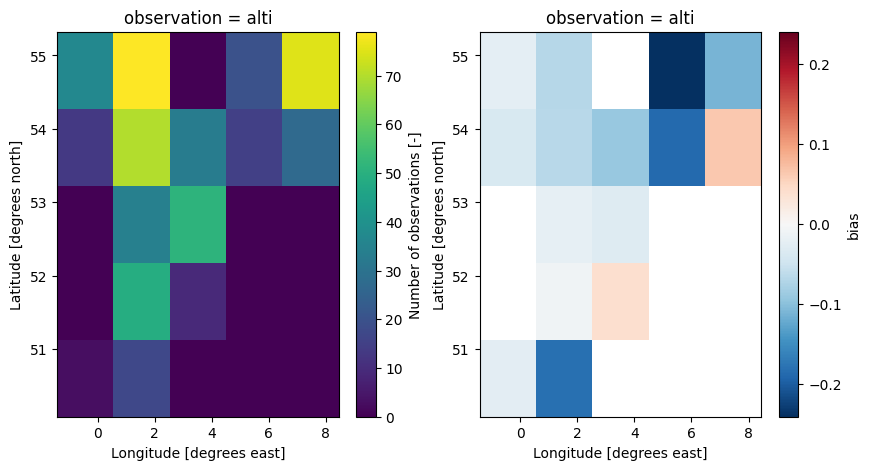

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
gs.n.plot(ax=axes[0])
gs.bias.plot(ax=axes[1]);

## Minimum number of observations

In [15]:
gs = cmp.gridded_skill(metrics=['bias'], n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
gs.n.plot(ax=axes[0])
gs.bias.plot(ax=axes[1]);

## Multiple bins - gridded skill for water level categories

Get data from comparer as dataframe and add a water level category as a new column.

In [ ]:
dftmp = cmp.data.to_dataframe()
dftmp["wl category"] = 'high'
dftmp.loc[dftmp['HD']<0, "wl category"] = 'low'

Add the "wl category" to the comparer's data structure.

In [ ]:
cmp.data["wl category"] = dftmp["wl category"]

Now aggregate the data by the new column (and x and y):

In [ ]:
gs = cmp.gridded_skill(by=['wl category'], metrics=['bias'], n_min=5)
gs

In [ ]:
gs.bias.plot();

## Multiple observations

Add fake 2nd observation to model

In [ ]:
import warnings

df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = ms.TrackObservation(df2, item=2, name='alti2')

warnings.filterwarnings('ignore', message="duplicate")
cmp2 = ms.match(o2, mr)

Extract, gridded skill, add attrs, plot.

In [ ]:
cmp = cmp + cmp2
gs = cmp.gridded_skill(metrics=['bias'], n_min=20)
gs.bias.data.attrs = dict(long_name="Bias of surface elevation", units="m")
gs.bias.plot(figsize=(10,5));